In [32]:
from pyspark.sql import SQLContext
from pyspark.sql import functions as sf
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import DateType
from datetime import date, timedelta
import datetime as dt
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.regression import RandomForestRegressionModel,RandomForestRegressor
from pyspark.sql.functions import col, avg, sum
import numpy as np
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
import pandas as pd
import pyspark
from collections import Counter

In [3]:
sc.stop()
sc = pyspark.SparkContext(master="spark://172.16.27.208:7077",appName="spark")
sc

<SparkContext master=spark://172.16.27.208:7077 appName=spark>

In [4]:
base_path = "/home/test5/Desktop/smart-meters-in-london/"
sqlcontext = SQLContext(sc)

In [5]:
cluster_feature = sqlcontext.read.csv(path=base_path+"bk=8_means_Feature.csv",header=True,inferSchema=True)
# cluster_feature = cluster_feature.drop("_c0","date2")
# cluster_feature = cluster_feature.withColumn("windSpeed",cluster_feature["windSpeed"].cast("float"))
# cluster_feature = cluster_feature.withColumn("dewPoint",cluster_feature["dewPoint"].cast("float"))
cluster_feature.printSchema()
type(cluster_feature)

root
 |-- _c0: integer (nullable = true)
 |-- cluster_id: integer (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- hour: integer (nullable = true)
 |-- energy(kWh/h): double (nullable = true)
 |-- month: integer (nullable = true)
 |-- weekDay: string (nullable = true)
 |-- 1_diff_energy_t_0: double (nullable = true)
 |-- 2_diff_energy_t_0: double (nullable = true)
 |-- 3_diff_energy_t_0: double (nullable = true)
 |-- 4_diff_energy_t_0: double (nullable = true)
 |-- 5_diff_energy_t_0: double (nullable = true)
 |-- 6_diff_energy_t_0: double (nullable = true)
 |-- 7_diff_energy_t_0: double (nullable = true)
 |-- 1_diff_energy_t_1: double (nullable = true)
 |-- 2_diff_energy_t_1: double (nullable = true)
 |-- 3_diff_energy_t_1: double (nullable = true)
 |-- 4_diff_energy_t_1: double (nullable = true)
 |-- 5_diff_energy_t_1: double (nullable = true)
 |-- 6_diff_energy_t_1: double (nullable = true)
 |-- 7_diff_energy_t_1: double (nullable = true)
 |-- 1_diff_energy_t_2: double (

pyspark.sql.dataframe.DataFrame

In [6]:
cluster_feature = cluster_feature.withColumn("holiday1",sf.when((col("Weekday/end")==1) | (col("holiday")==1),1).otherwise(0))
cluster_feature = cluster_feature.drop("_c0","diff_energy_week_t_1","date2","holiday","month","Weekday/end")
cluster_feature = cluster_feature.withColumnRenamed("holiday1","holiday")
cluster_feature.take(1)

[Row(cluster_id=1, date=datetime.datetime(2013, 1, 1, 0, 0), hour=0, energy(kWh/h)=265.413, weekDay='Tue', 1_diff_energy_t_0=230.108, 2_diff_energy_t_0=242.838, 3_diff_energy_t_0=239.363, 4_diff_energy_t_0=231.928, 5_diff_energy_t_0=230.906, 6_diff_energy_t_0=236.636, 7_diff_energy_t_0=235.955, 1_diff_energy_t_1=278.6, 2_diff_energy_t_1=282.455, 3_diff_energy_t_1=289.14, 4_diff_energy_t_1=281.541, 5_diff_energy_t_1=268.213, 6_diff_energy_t_1=272.572, 7_diff_energy_t_1=277.427, 1_diff_energy_t_2=346.241, 2_diff_energy_t_2=334.529, 3_diff_energy_t_2=342.058, 4_diff_energy_t_2=342.666, 5_diff_energy_t_2=326.166, 6_diff_energy_t_2=304.912, 7_diff_energy_t_2=333.314, diff_energy_week_t_2=217.882, diff_energy_week_t_3=218.23, diff_energy_week_t_4=212.166, rnk=32, mean_1=283.6334583333333, mean_2=283.55745833333333, mean_3=283.9150833333333, mean_4=279.71179166666667, mean_5=276.9005, mean_6=269.6797916666667, mean_7=286.57225, min_1=136.298, max_1=468.535, min_2=133.018, max_2=438.373, min_3

In [7]:
outputCols = ["weekDay_index","precipType_index","summary_index"]
df_encoded = cluster_feature
df_encoded = df_encoded.na.drop()
for col in outputCols: 
    encoder = OneHotEncoder(inputCol=col, outputCol="category_{}".format(col))
    df_encoded = encoder.transform(df_encoded).cache()
df_encoded = df_encoded.drop("rnk")
df_encoded.printSchema()

root
 |-- cluster_id: integer (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- hour: integer (nullable = true)
 |-- energy(kWh/h): double (nullable = true)
 |-- weekDay: string (nullable = true)
 |-- 1_diff_energy_t_0: double (nullable = true)
 |-- 2_diff_energy_t_0: double (nullable = true)
 |-- 3_diff_energy_t_0: double (nullable = true)
 |-- 4_diff_energy_t_0: double (nullable = true)
 |-- 5_diff_energy_t_0: double (nullable = true)
 |-- 6_diff_energy_t_0: double (nullable = true)
 |-- 7_diff_energy_t_0: double (nullable = true)
 |-- 1_diff_energy_t_1: double (nullable = true)
 |-- 2_diff_energy_t_1: double (nullable = true)
 |-- 3_diff_energy_t_1: double (nullable = true)
 |-- 4_diff_energy_t_1: double (nullable = true)
 |-- 5_diff_energy_t_1: double (nullable = true)
 |-- 6_diff_energy_t_1: double (nullable = true)
 |-- 7_diff_energy_t_1: double (nullable = true)
 |-- 1_diff_energy_t_2: double (nullable = true)
 |-- 2_diff_energy_t_2: double (nullable = true)
 |-- 3_d

In [8]:
inputCols = ["weekDay","precipType","summary",]
columns = df_encoded.columns
feature_col = columns[4:]
feature_col.append(columns[2])
feature_col = set(feature_col) - set(inputCols)
feature_col = feature_col - set(outputCols)
feature_col = list(feature_col)
df_encoded = df_encoded.na.drop()
len(feature_col)

vecAssembler = VectorAssembler(inputCols=feature_col, outputCol="features")
df_feature = vecAssembler.transform(df_encoded)
df_feature.take(1)

[Row(cluster_id=1, date=datetime.datetime(2013, 1, 1, 0, 0), hour=0, energy(kWh/h)=265.413, weekDay='Tue', 1_diff_energy_t_0=230.108, 2_diff_energy_t_0=242.838, 3_diff_energy_t_0=239.363, 4_diff_energy_t_0=231.928, 5_diff_energy_t_0=230.906, 6_diff_energy_t_0=236.636, 7_diff_energy_t_0=235.955, 1_diff_energy_t_1=278.6, 2_diff_energy_t_1=282.455, 3_diff_energy_t_1=289.14, 4_diff_energy_t_1=281.541, 5_diff_energy_t_1=268.213, 6_diff_energy_t_1=272.572, 7_diff_energy_t_1=277.427, 1_diff_energy_t_2=346.241, 2_diff_energy_t_2=334.529, 3_diff_energy_t_2=342.058, 4_diff_energy_t_2=342.666, 5_diff_energy_t_2=326.166, 6_diff_energy_t_2=304.912, 7_diff_energy_t_2=333.314, diff_energy_week_t_2=217.882, diff_energy_week_t_3=218.23, diff_energy_week_t_4=212.166, mean_1=283.6334583333333, mean_2=283.55745833333333, mean_3=283.9150833333333, mean_4=279.71179166666667, mean_5=276.9005, mean_6=269.6797916666667, mean_7=286.57225, min_1=136.298, max_1=468.535, min_2=133.018, max_2=438.373, min_3=130.779

In [9]:
df_feature = df_feature.withColumnRenamed("energy(kWh/h)","label")
df_feature = df_feature.withColumn("date",df_feature["date"].cast(DateType()))
df_feature.printSchema()

root
 |-- cluster_id: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- hour: integer (nullable = true)
 |-- label: double (nullable = true)
 |-- weekDay: string (nullable = true)
 |-- 1_diff_energy_t_0: double (nullable = true)
 |-- 2_diff_energy_t_0: double (nullable = true)
 |-- 3_diff_energy_t_0: double (nullable = true)
 |-- 4_diff_energy_t_0: double (nullable = true)
 |-- 5_diff_energy_t_0: double (nullable = true)
 |-- 6_diff_energy_t_0: double (nullable = true)
 |-- 7_diff_energy_t_0: double (nullable = true)
 |-- 1_diff_energy_t_1: double (nullable = true)
 |-- 2_diff_energy_t_1: double (nullable = true)
 |-- 3_diff_energy_t_1: double (nullable = true)
 |-- 4_diff_energy_t_1: double (nullable = true)
 |-- 5_diff_energy_t_1: double (nullable = true)
 |-- 6_diff_energy_t_1: double (nullable = true)
 |-- 7_diff_energy_t_1: double (nullable = true)
 |-- 1_diff_energy_t_2: double (nullable = true)
 |-- 2_diff_energy_t_2: double (nullable = true)
 |-- 3_diff_energy_t_

In [43]:
def get_aggregate(df):
    list = ["date","hour"]
    df = df.groupBy(list).agg(sum("label"),sum("prediction"))    
    return df
def select_predicted_actual(df,date,LCLid=None):
    list = []
    if LCLid != None:
        list = df.where((df["LCLid"] == LCLid) & (df["date"] == date)).select("label","prediction").collect()
    else:
        list = df.where((df["date"] == date)).select("label","prediction").collect()
    actual = [int(row['label']) for row in list]
    predicted = [int(row['prediction']) for row in list]
    return actual,predicted

def populate_precision_recall(actual,predicted,precision,recall,predicted_peak_period,actual_peak_period):
    actual, predicted = np.array(actual),np.array(predicted)
    actual_std, predicted_std = np.std(actual), np.std(predicted)
    actual_mean, predicted_mean = np.mean(actual),np.mean(predicted)
    actual_threshhold, predicted_threshhold = actual_std + actual_mean,predicted_std+predicted_mean
    
    y_label, y_predicted = [],[]
    for power,power1 in zip(actual,predicted):
        y_label.append(1) if power > actual_threshhold else y_label.append(0)
        y_predicted.append(1) if power1 > predicted_threshhold else y_predicted.append(0)
    
    predicted_peak_period.append(y_predicted)
    actual_peak_period.append(y_label)
    
    counts = Counter(zip(y_predicted,y_label))
    tp = counts[1,1]
    fp = counts[1,0]
    tn = counts[0,0]
    fn = counts[0,1]
    
    recall.append((tp/float(tp+fn)) if tp+fn else 0)
    precision.append((tp+tn)/24.0)
    return precision,recall, predicted_peak_period,actual_peak_period

In [28]:
train_df_cluster = []
test_df_cluster = []
num_of_cluster = 8
for cluster_id in range(num_of_cluster):
    train_df = df_feature.where((df_feature["cluster_id"] == cluster_id) & (df_feature["date"] <= date(2013,10,31)))
    test_df = df_feature.where((df_feature["cluster_id"] == cluster_id) & (df_feature["date"] > date(2013,10,31)))# & (df_feature["date"] <= date(2013,1,2)))
    print("Train_point = {}, Test_point = {}, cId = {}".format(train_df.count(),test_df.count(),cluster_id))
    train_df_cluster.append(train_df)
    test_df_cluster.append(test_df)

Train_point = 7288, Test_point = 1464, cId = 0
Train_point = 7288, Test_point = 1464, cId = 1
Train_point = 7288, Test_point = 1464, cId = 2
Train_point = 7288, Test_point = 1464, cId = 3
Train_point = 7288, Test_point = 1464, cId = 4
Train_point = 7288, Test_point = 1464, cId = 5
Train_point = 7288, Test_point = 1464, cId = 6
Train_point = 7288, Test_point = 1464, cId = 7


In [30]:
pred_val = []
flag = 0
for cluster_id in range(num_of_cluster):
    rf = RandomForestRegressor(numTrees=20,maxDepth=10,maxBins=128,seed=4)
    model = rf.fit(train_df_cluster[cluster_id])
#     model.save(base_path+"/Model/rf_bkm/rf_model_bkm_{}".format(cluster_id))
    rf_pred_val = model.transform(test_df_cluster[cluster_id])
    if flag == 0:
        pred_val = sqlcontext.createDataFrame([],rf_pred_val.schema)
        flag = 1
    pred_val = pred_val.union(rf_pred_val)
    pred_val = pred_val.cache()

In [31]:
aggregate_df = get_aggregate(pred_val)
aggregate_df = aggregate_df.withColumnRenamed("sum(label)","label")
aggregate_df = aggregate_df.withColumnRenamed("sum(prediction)","prediction")

In [48]:
train_start_date = date(2013,11,1)
train_end_date = date(2013,12,31)
y_date = []
predicted_peak_period = []
actual_peak_period = []
precision = []
recall = [] 
while train_start_date <= train_end_date:
    print(train_start_date)
    y_actual,y_pred = select_predicted_actual(aggregate_df,train_start_date)
    if len(y_actual) == 0:
        train_start_date = train_start_date + timedelta(1)
        continue
    precision,recall,predicted_peak_period,actual_peak_period = populate_precision_recall(y_actual,y_pred,precision,recall,predicted_peak_period,actual_peak_period)
    y_date.append(train_start_date)
    train_start_date = train_start_date + timedelta(1)

2013-11-01
2013-11-02
2013-11-03
2013-11-04
2013-11-05
2013-11-06
2013-11-07
2013-11-08
2013-11-09
2013-11-10
2013-11-11
2013-11-12
2013-11-13
2013-11-14
2013-11-15
2013-11-16
2013-11-17
2013-11-18
2013-11-19
2013-11-20
2013-11-21
2013-11-22
2013-11-23
2013-11-24
2013-11-25
2013-11-26
2013-11-27
2013-11-28
2013-11-29
2013-11-30
2013-12-01
2013-12-02
2013-12-03
2013-12-04
2013-12-05
2013-12-06
2013-12-07
2013-12-08
2013-12-09
2013-12-10
2013-12-11
2013-12-12
2013-12-13
2013-12-14
2013-12-15
2013-12-16
2013-12-17
2013-12-18
2013-12-19
2013-12-20
2013-12-21
2013-12-22
2013-12-23
2013-12-24
2013-12-25
2013-12-26
2013-12-27
2013-12-28
2013-12-29
2013-12-30
2013-12-31


In [45]:
from statistics import mean
print("Mean accuracy = {}, Mean recall = {}".format(mean(precision),mean(recall)))

Mean accuracy = 0.9842896174863388, Mean recall = 0.9644808743169399


In [90]:
actual_predicted = aggregate_df.where((aggregate_df.date==date(2013,11,16))).select("label","prediction").toPandas()

[1, 3, 5, 6, 18]


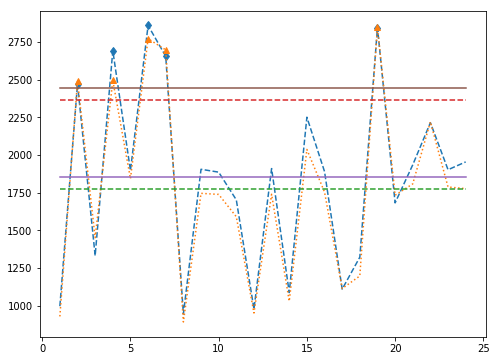

In [91]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
mark_actual,mark_predicted = [],[]
for i in range(24):
    if predicted_peak_period[15][i] == 1:
        mark_predicted.append(i)
    if actual_peak_period[15][i] == 1:
        mark_actual.append(i)
print(mark_predicted)
ax.plot(np.arange(1,25),actual_predicted["label"],linestyle = '--',marker="d",markevery=mark_predicted)
ax.plot(np.arange(1,25),actual_predicted["prediction"],linestyle = ':',marker="^",markevery=mark_actual)
ax.plot(np.arange(1,25),[actual_predicted["prediction"].mean()]*24,linestyle='--')
ax.plot(np.arange(1,25),[actual_predicted["prediction"].mean()+actual_predicted["prediction"].std()]*24,linestyle='--')
ax.plot(np.arange(1,25),[actual_predicted["label"].mean()]*24,linestyle='-')
ax.plot(np.arange(1,25),[actual_predicted["label"].mean()+actual_predicted["label"].std()]*24,linestyle='-')


In [58]:
actual_predicted["prediction"].std()

628.9004348823094

In [87]:
y_date[54]

datetime.date(2013, 12, 25)

In [92]:
predicted_peak_period[54]

[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0]

In [93]:
actual_peak_period[54]

[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]